# Analyze transcriptome coverage of Ribo-seq reads

## Load libraries

In [1]:
options(warn = -1, repr.matrix.max.rows = 15)

suppressPackageStartupMessages({
  library(rtracklayer)
  library(GenomicAlignments)
  library(plyranges)
  library(tidyverse)
  library(rasilabRtemplates)
})

cbPalette_12 <- c(
  "#DDCC77", "#CC6677", "#6699CC", "#661100", "#117733", "#999933",
  "#332288", "#AA4499", "#44AA99", "#882255", "#88CCEE", "#999999"
)


ieg <- c("FOS", "JUN", "ATF3", "EGR1", "DUSP1", "IER2", "MYC", "GPR50", "ADAMST1", "RHOB", "TIMP3", "JUND")

near_cognate_start_codons <- c("ATG", "CTG", "GTG", "TTG", "ATA", "ATC", "ATT", "AAG", "AGG", "ACG")
names(near_cognate_start_codons) <- near_cognate_start_codons

theme_set(theme_rasilab() +
  theme(
    axis.line = element_line(color = "grey"),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))
  ))


## Load TIS efficiencies using dint PWM from Noderer 2014 

In [2]:
noderer_s2 <- read_tsv("../tables/noderer_2014_dint_pwm_tis.tsv", show_col_types = F, comment = "#") %>%
  mutate(sequence = str_replace_all(sequence, "U", "T")) %>%
  print()

# A tibble: 65,536 × 4
   sequence    efficiency lower.bound upper.bound
   <chr>            <dbl>       <dbl>       <dbl>
 1 TTCATCATGCA        150         139         161
 2 GCGAGTATGGC        149         139         161
 3 ACGAGAATGGC        148         136         160
 4 ATCATCATGCA        147         136         158
 5 ACGAGTATGGC        145         134         157
 6 ACGGGAATGGC        144         133         157
 7 ATGGGAATGGC        144         132         158
 8 ACGAGGATGGC        144         132         156
 9 ATGAGAATGGC        143         131         156
10 GTCATCATGCA        142         132         154
# … with 65,526 more rows


## Load sample annotations

In [3]:
sample_annotations <- read_csv("../annotations/sample_annotations.csv", show_col_types = F) %>% 
  filter(str_detect(sample_name, "mono")) %>% 
  extract(sample_name, c("sample_name", "replicate"), "(.*)_(.*)") %>% 
  select(sample_id, sample_name, replicate)

sample_annotations

sample_id,sample_name,replicate
<chr>,<chr>,<chr>
225p41,sggcn1_hht_mono,rep1
225p43,sggcn1_dmso_mono,rep1
225p45,sgfluc_hht_mono,rep1
225p47,sgfluc_dmso_mono,rep1
225p61,sggcn1_hht_mono,rep2
225p62,sggcn1_dmso_mono,rep2
225p63,sgfluc_hht_mono,rep2
225p64,sgfluc_dmso_mono,rep2


## Load transcript annotations

In [4]:
tx_annotations <- read_gff2("../data/mane/MANE.GRCh38.v1.3.ensembl_genomic.gtf") 

seqlevelsStyle(tx_annotations) <- "UCSC"

tx_annotations

GRanges object with 521182 ranges and 15 metadata columns:
           seqnames              ranges strand |         source        type
              <Rle>           <IRanges>  <Rle> |       <factor>    <factor>
       [1]     chr1     3069168-3438621      + | ensembl_havana gene       
       [2]     chr1     3069203-3438621      + | ensembl_havana transcript 
       [3]     chr1     3069203-3069296      + | ensembl_havana exon       
       [4]     chr1     3069260-3069296      + | ensembl_havana CDS        
       [5]     chr1     3069260-3069262      + | ensembl_havana start_codon
       ...      ...                 ...    ... .            ...         ...
  [521178]     chrX 152759843-152760219      + |         havana  exon      
  [521179]     chrX 152759843-152759909      + |         havana  CDS       
  [521180]     chrX 152759910-152759912      + |         havana  stop_codon
  [521181]     chrX 152759218-152759370      + |         havana  UTR       
  [521182]     chrX 152759910

## Parse gene names

In [5]:
tx_gene_names <- tx_annotations %>% 
  filter(type == "transcript") %>% 
  as_tibble() %>% 
  select(transcript_id, gene_name, transcript_name)

tx_gene_names

transcript_id,gene_name,transcript_name
<chr>,<chr>,<chr>
ENST00000270722.10,PRDM16,PRDM16-201
ENST00000447513.7,PEX10,PEX10-202
ENST00000356607.9,PEX14,PEX14-201
ENST00000378486.8,PLCH2,PLCH2-203
ENST00000328089.11,SPSB1,SPSB1-201
⋮,⋮,⋮
ENST00000423759.6,TAF1,TAF1-204
ENST00000374571.5,PJA1,PJA1-202
ENST00000644876.2,DDX3X,DDX3X-244


## Parse transcript coordinates

In [6]:
tx <- tx_annotations %>% 
  filter(type == "exon") %>% 
  split(.$transcript_id)

## Load  transcriptome alignments

In [7]:
aln <- list.files("../data/alignments/", pattern = ".bam$", full.names = T) %>% 
  as_tibble_col("file") %>% 
  mutate(sample_id = str_extract(file, "225p\\d+")) %>% 
  inner_join(sample_annotations, by = "sample_id") %>% 
  mutate(aln = map(file, . %>% readGAlignments %>% as_data_frame)) %>% 
  select(-file) %>% 
  unnest(aln)

aln

sample_id,sample_name,replicate,seqnames,strand,cigar,qwidth,start,end,width,njunc
<chr>,<chr>,<chr>,<fct>,<fct>,<chr>,<int>,<int>,<int>,<int>,<int>
225p41,sggcn1_hht_mono,rep1,ENST00000270722.10,+,23M,23,3407,3429,23,0
225p41,sggcn1_hht_mono,rep1,ENST00000447513.7,+,31M,31,49,79,31,0
225p41,sggcn1_hht_mono,rep1,ENST00000447513.7,+,32M,32,105,136,32,0
225p41,sggcn1_hht_mono,rep1,ENST00000447513.7,+,31M,31,107,137,31,0
225p41,sggcn1_hht_mono,rep1,ENST00000447513.7,+,30M,30,110,139,30,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
225p64,sgfluc_dmso_mono,rep2,ENST00000710304.1,+,29M,29,452,480,29,0
225p64,sgfluc_dmso_mono,rep2,ENST00000710304.1,+,29M,29,452,480,29,0
225p64,sgfluc_dmso_mono,rep2,ENST00000710304.1,+,30M,30,452,481,30,0


## Calculate start codon positions relative to transcript coordinates

In [8]:
start_codons_tx <- tx_annotations %>% 
  filter(type == "start_codon") %>% 
  GenomicFeatures::mapToTranscripts(tx) %>%
  as_tibble() %>% 
  select(seqnames, start, end) %>%
  print()

# A tibble: 19,440 × 3
   seqnames           start   end
   <fct>              <int> <int>
 1 ENST00000270722.10    58    60
 2 ENST00000447513.7     63    65
 3 ENST00000356607.9     18    20
 4 ENST00000378486.8    301   303
 5 ENST00000328089.11   328   330
 6 ENST00000377424.9    100   102
 7 ENST00000377205.6     98   100
 8 ENST00000294484.7    222   224
 9 ENST00000378412.8    189   191
10 ENST00000376008.3    475   477
# … with 19,430 more rows


## Calculate UTR and CDS lengths

In [9]:
utr_cds_annotations <- tx_annotations %>% 
  filter(type %in% c("UTR", "CDS")) 

utr_cds_length <- utr_cds_annotations %>%
  GenomicFeatures::mapToTranscripts(tx) %>%
  as_tibble() %>% 
  mutate(type = utr_cds_annotations$type[xHits]) %>%
  left_join(start_codons_tx, by = "seqnames", suffix = c("", "_start")) %>%
  left_join(tx_gene_names, by = c("seqnames" = "transcript_id")) %>%
  mutate(type = case_when(
    type == "UTR" & start < start_start ~ "UTR5",
    type == "UTR" & start > start_start ~ "UTR3",
    TRUE ~ "CDS"
  )) %>%
  group_by(gene_name, type) %>%
  summarize(start = min(start), .groups = "drop") %>%
  print()

# A tibble: 57,190 × 3
   gene_name type  start
   <chr>     <chr> <int>
 1 A1BG      CDS      56
 2 A1BG      UTR3   1541
 3 A1BG      UTR5      1
 4 A1CF      CDS     141
 5 A1CF      UTR3   1899
 6 A1CF      UTR5      1
 7 A2M       CDS      71
 8 A2M       UTR3   4493
 9 A2M       UTR5      1
10 A2ML1     CDS      32
# … with 57,180 more rows


## Plot read profile around start codons

- Based on this, subtracting 13nt from the 5'end of reads seems reasonable for aligning P-site of the ribosome with 1nt on either side for getting total peak counts
- We can limit ribosome footprints to [27, 33]nt.

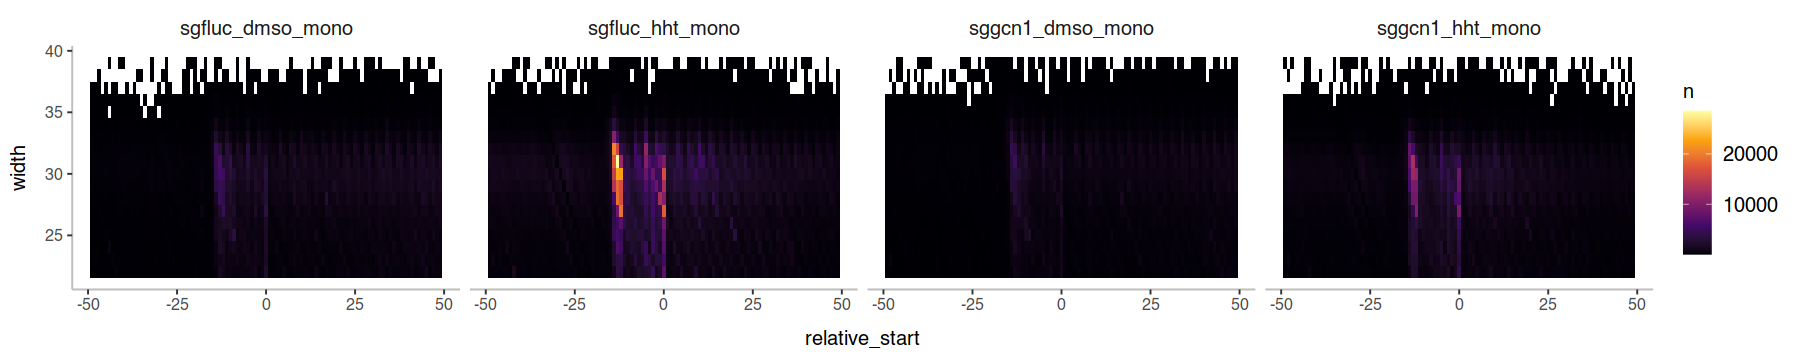

In [10]:
options(repr.plot.width = 15, repr.plot.height = 3)

plot_data <- aln %>% 
  left_join(start_codons_tx, by = "seqnames", suffix = c("", "_start")) %>% 
  filter(!is.na(start_start)) %>% 
  mutate(relative_start = start - start_start) %>% 
  filter(relative_start < 500, relative_start > -50) %>% 
  filter(width > 20, width < 40) %>% 
  group_by(sample_name, width, relative_start) %>% 
  count()

plot_data %>% 
  filter(relative_start < 50) %>% 
  ggplot(aes(x = relative_start, y = width, fill = n)) +
  facet_wrap(~ sample_name, ncol = 4, scales = "free_x") +
  geom_tile() +
  scale_fill_viridis_c(option = "B")

## Normalized profile of counts around start codons

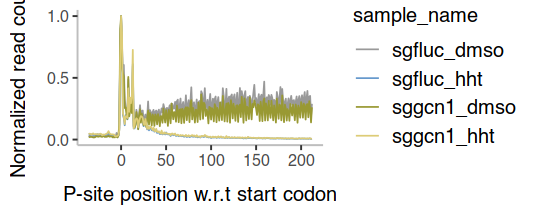

In [11]:
options(repr.plot.width = 4.5, repr.plot.height = 1.8)

plot_data  %>% 
  filter(width >= 27, width <= 33, relative_start < 200) %>%
  group_by(sample_name , relative_start) %>%
  summarize(n = sum(n), .groups = "drop") %>%
  group_by(sample_name) %>% 
  mutate(n = n / max(n)) %>%
  ungroup() %>% 
  # filter(str_detect(sample_name, "hht")) %>% 
  mutate(sample_name = str_replace(sample_name, "_mono", "")) %>% 
  ggplot(aes(x = relative_start + 13, y = n, color = sample_name)) +
  scale_color_manual(values = cbPalette_12[c(12,3,6,1)]) +
  geom_line() +
  scale_y_continuous(breaks = c(0, 0.5, 1)) +
  labs(x = "P-site position w.r.t start codon", y = "Normalized read count")

ggsave("../figures/riboseq_metadensity.pdf", width = 4.5, height = 1.8)

## Is the relative read density before and after annotated start codon different?

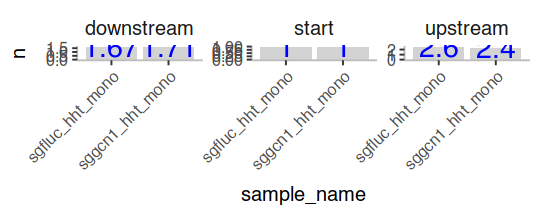

In [12]:
plot_data  %>%
  filter(width >= 27, width <= 33, relative_start < 200) %>%
  mutate(pos = case_when(
    relative_start < 0 ~ "upstream",
    relative_start >= 0 & relative_start < 15 ~ "start",
    relative_start >= 15  ~ "downstream"
  )) %>%
  filter(!is.na(pos)) %>%
  group_by(sample_name, pos) %>%
  summarise(n = sum(n), .groups = "drop") %>%
  group_by(sample_name) %>%
  mutate(n = round(n / n[pos == "start"],2)) %>%
  ungroup() %>%
  filter(str_detect(sample_name, "hht")) %>%
  ggplot(aes(x = sample_name, y = n)) +
  facet_wrap(~ pos, scales = "free_y") +
  geom_col(fill = "light grey", stroke = NA) +
  geom_text(aes(label = n), color = "blue", size = 6) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


## Calculate gene counts from alignments

In [13]:
gene_counts <- aln %>% 
  filter(width >= 27, width <= 33) %>% 
  group_by(sample_name, seqnames) %>% 
  count() %>% 
  ungroup() %>%
  left_join(tx_gene_names, by = c("seqnames" = "transcript_id")) %>% 
  print()

# A tibble: 53,638 × 5
   sample_name      seqnames               n gene_name transcript_name
   <chr>            <chr>              <int> <chr>     <chr>          
 1 sgfluc_dmso_mono ENST00000270722.10    58 PRDM16    PRDM16-201     
 2 sgfluc_dmso_mono ENST00000447513.7     77 PEX10     PEX10-202      
 3 sgfluc_dmso_mono ENST00000356607.9    177 PEX14     PEX14-201      
 4 sgfluc_dmso_mono ENST00000328089.11    47 SPSB1     SPSB1-201      
 5 sgfluc_dmso_mono ENST00000377424.9      1 SLC2A5    SLC2A5-202     
 6 sgfluc_dmso_mono ENST00000377205.6     17 NMNAT1    NMNAT1-201     
 7 sgfluc_dmso_mono ENST00000378412.8      5 MMEL1     MMEL1-201      
 8 sgfluc_dmso_mono ENST00000376008.3     30 TMEM51    TMEM51-201     
 9 sgfluc_dmso_mono ENST00000375592.8    154 FBXO42    FBXO42-201     
10 sgfluc_dmso_mono ENST00000375341.8    122 ALDH4A1   ALDH4A1-202    
# … with 53,628 more rows


## Look at counts of candidate genes of interest

In [14]:
gene_counts  %>% 
  filter(gene_name %in% ieg | gene_name %in% c("GAPDH", "ACTB", "DDIT3", "ASNS", "WARS", "ATF4")) %>% 
  select(sample_name, gene_name, n) %>% 
  pivot_wider(names_from = gene_name, values_from = n) 

sample_name,JUN,ATF3,RHOB,EGR1,DUSP1,ASNS,ACTB,MYC,GAPDH,DDIT3,FOS,JUND,IER2,ATF4,TIMP3,GPR50
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
sgfluc_dmso_mono,850,101,590,17,143,1821,51045,1213,38304,3,23,150,154,2737,292,159
sgfluc_hht_mono,1029,61,404,7,192,368,10730,486,16988,31,10,153,123,2798,79,15
sggcn1_dmso_mono,448,64,358,9,96,956,29154,805,21146,5,4,130,120,1526,130,164
sggcn1_hht_mono,1960,72,294,128,257,192,5571,317,8658,10,34,115,187,1437,41,25


## Calculate fold changes between different samples

In [15]:
gene_counts  %>% 
  group_by(seqnames) %>% 
  mutate(total_counts = sum(n)) %>%
  ungroup() %>% 
  filter(total_counts > 50) %>% 
  pivot_wider(names_from = sample_name, values_from = n) %>% 
  mutate(fluc_hht_by_dmso = sgfluc_hht_mono / sgfluc_dmso_mono) %>% 
  mutate(gcn1_hht_by_dmso = sggcn1_hht_mono / sggcn1_dmso_mono) %>% 
  mutate(dmso_gcn1_by_fluc = sggcn1_dmso_mono / sgfluc_dmso_mono) %>% 
  mutate(hht_gcn1_by_fluc = sggcn1_hht_mono / sgfluc_hht_mono) %>% 
  filter(across(matches("_by_"), ~ !is.na(.))) %>%
  mutate(across(matches("_by_"),.fns = ~ round(. - median(.), 2))) %>% 
  arrange(desc(hht_gcn1_by_fluc)) %>% 
  write_csv("../tables/gcn1_hht_gene_counts_lfc.csv")

## Trim alignments based on read length and P-site distance

In [16]:
aln_counts <- aln %>% 
  GRanges() %>% 
  filter(width >= 27, width <= 33) %>% 
  # we remove an extra nt so that we can look for overlap with any 3 nt in the codon
  narrow(start = 15, width = 1) %>%
  as_tibble() %>% 
  group_by(seqnames, start, end, sample_name) %>%
  summarize(score = sum(width), .groups = "drop") %>%
  ungroup() %>% 
  mutate(psite = start) %>%
  GRanges() %>%
  print()

GRanges object with 3318545 ranges and 3 metadata columns:
                      seqnames    ranges strand |      sample_name     score
                         <Rle> <IRanges>  <Rle> |      <character> <integer>
        [1] ENST00000000233.10        20      * |  sggcn1_hht_mono         1
        [2] ENST00000000233.10        88      * |  sgfluc_hht_mono         6
        [3] ENST00000000233.10        89      * |  sgfluc_hht_mono        19
        [4] ENST00000000233.10        89      * |  sggcn1_hht_mono         5
        [5] ENST00000000233.10        90      * |  sgfluc_hht_mono        39
        ...                ...       ...    ... .              ...       ...
  [3318541]  ENST00000715685.1      1664      * | sgfluc_dmso_mono         1
  [3318542]  ENST00000715685.1      2109      * | sggcn1_dmso_mono         1
  [3318543]  ENST00000715685.1      2135      * |  sgfluc_hht_mono         1
  [3318544]  ENST00000715685.1      2316      * |  sggcn1_hht_mono         1
  [3318545]  ENST

## Load genome sequence

In [17]:
genome <- BSgenome.Hsapiens.UCSC.hg38::BSgenome.Hsapiens.UCSC.hg38

## Extract transcript sequences

In [18]:
tx_seq <- GenomicFeatures::extractTranscriptSeqs(genome, tx)

## Plotr read coverage for JUN

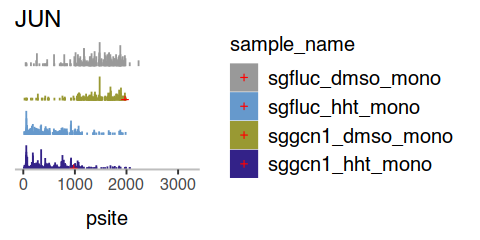

In [131]:
options(repr.plot.width = 4, repr.plot.height = 2)

gene <- "JUN"
plot_data <- aln_counts  %>%
  as_tibble() %>%
  left_join(tx_gene_names, by = c("seqnames" = "transcript_id")) %>%
  filter(gene_name == gene)

tx_width <- tx_gene_names %>% 
  filter(gene_name == gene) %>% 
  pull(transcript_id) %>% 
  tx_seq[.] %>% 
  width()

plot_data <- tx_width %>% 
  seq(1, .) %>% 
  as_tibble_col(column_name = "start") %>% 
  left_join(plot_data, by = "start") %>% 
  complete(sample_name, start) %>% 
  mutate(score = ifelse(is.na(score), 0, score)) %>% 
  filter(!is.na(sample_name)) %>% 
  mutate(drug = str_extract(sample_name, "dmso|hht")) %>%
  mutate(sgrna = str_extract(sample_name, "gcn1|fluc"))

gene_plot <- plot_data  %>% 
  inner_join(utr_cds_length, by = c("psite" = "start", "gene_name"))


plot_data %>%
  ggplot(aes(x = psite, y = score, fill = sample_name, color = sample_name)) +
  facet_wrap(~ drug + sgrna, scales = "free_y", ncol = 1) +
  geom_col() +
  geom_point(aes(x = psite, y = 0), size = 1, shape = "plus", color = "red", data = gene_plot, vjust = 1, hjust = 0.5) +
  labs(title = gene) +
  theme(strip.text.x = element_blank(),
    axis.title.y = element_blank(),
  axis.text.y = element_blank(),
  axis.ticks.y = element_blank(),
  axis.line.y = element_blank()
  ) +
  scale_fill_manual(values = cbPalette_12[c(12,3,6,7)]) +
  scale_color_manual(values = cbPalette_12[c(12,3,6,7)]) +
  scale_x_continuous(limits=c(1, tx_width))

ggsave("../figures/jun_riboseq.pdf", width = 4, height = 2)

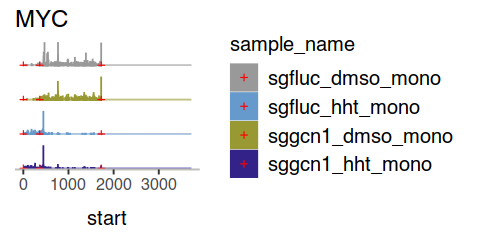

In [143]:
options(repr.plot.width = 4, repr.plot.height = 2)

gene <- "MYC"
plot_data <- aln_counts  %>%
  as_tibble() %>%
  left_join(tx_gene_names, by = c("seqnames" = "transcript_id")) %>%
  filter(gene_name == gene)

tx_width <- tx_gene_names %>% 
  filter(gene_name == gene) %>% 
  pull(transcript_id) %>% 
  tx_seq[.] %>% 
  width()

plot_data <- tx_width %>% 
  seq(1, .) %>% 
  as_tibble_col(column_name = "start") %>% 
  left_join(plot_data, by = "start") %>% 
  complete(sample_name, start, gene_name) %>% 
  mutate(score = ifelse(is.na(score), 0, score)) %>% 
  filter(!is.na(sample_name), !is.na(gene_name)) %>% 
  mutate(drug = str_extract(sample_name, "dmso|hht")) %>%
  mutate(sgrna = str_extract(sample_name, "gcn1|fluc"))

gene_plot <- plot_data  %>% 
  inner_join(utr_cds_length, by = c("start", "gene_name"))


plot_data %>%
  ggplot(aes(x = start, y = score, fill = sample_name, color = sample_name)) +
  facet_wrap(~ drug + sgrna, scales = "free_y", ncol = 1) +
  geom_col() +
  geom_point(aes(x = start, y = 0), size = 1, shape = "plus", color = "red", data = gene_plot, vjust = 1, hjust = 0.5) +
  labs(title = gene) +
  theme(strip.text.x = element_blank(),
    axis.title.y = element_blank(),
  axis.text.y = element_blank(),
  axis.ticks.y = element_blank(),
  axis.line.y = element_blank()
  ) +
  scale_fill_manual(values = cbPalette_12[c(12,3,6,7)]) +
  scale_color_manual(values = cbPalette_12[c(12,3,6,7)])

ggsave("../figures/myc_riboseq.pdf", width = 4, height = 2)

In [141]:
utr_cds_length  %>% 
  filter(gene_name == "MYC")

gene_name,type,start
<chr>,<chr>,<int>
MYC,CDS,364
MYC,UTR3,1726
MYC,UTR5,1


In [142]:
plot_data  %>% 
  filter(start == 364)

sample_name,start,gene_name,seqnames,end,width,strand,score,psite,transcript_name,drug,sgrna
<chr>,<int>,<chr>,<chr>,<int>,<int>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>
sgfluc_dmso_mono,364,MYC,NA,NA,NA,NA,0,NA,NA,dmso,fluc
sgfluc_hht_mono,364,MYC,NA,NA,NA,NA,0,NA,NA,hht,fluc
sggcn1_dmso_mono,364,MYC,NA,NA,NA,NA,0,NA,NA,dmso,gcn1
sggcn1_hht_mono,364,MYC,ENST00000621592.8,364,1,*,1,364,MYC-206,hht,gcn1


In [122]:
plot_data  %>% 
  arrange(desc(start))

sample_name,start,seqnames,end,width,strand,score,psite,gene_name,transcript_name,drug,sgrna
<chr>,<int>,<chr>,<int>,<int>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
sgfluc_dmso_mono,3257,NA,NA,NA,NA,0,NA,NA,NA,dmso,fluc
sgfluc_hht_mono,3257,NA,NA,NA,NA,0,NA,NA,NA,hht,fluc
sggcn1_dmso_mono,3257,NA,NA,NA,NA,0,NA,NA,NA,dmso,gcn1
sggcn1_hht_mono,3257,NA,NA,NA,NA,0,NA,NA,NA,hht,gcn1
sgfluc_dmso_mono,3256,NA,NA,NA,NA,0,NA,NA,NA,dmso,fluc
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
sggcn1_hht_mono,2,NA,NA,NA,NA,0,NA,NA,NA,hht,gcn1
sgfluc_dmso_mono,1,NA,NA,NA,NA,0,NA,NA,NA,dmso,fluc
sgfluc_hht_mono,1,NA,NA,NA,NA,0,NA,NA,NA,hht,fluc


In [112]:
seq(tx_seq["ENST00000371222.4"])

[1] 1

In [110]:
utr_cds_length  %>% 
  filter(gene_name == "JUN")

gene_name,type,start
<chr>,<chr>,<int>
JUN,CDS,978
JUN,UTR3,1971
JUN,UTR5,1


In [47]:
plot_data  %>% 
arrange(start)

seqnames,start,end,width,strand,sample_name,score,psite,gene_name,transcript_name,drug,sgrna
<chr>,<int>,<int>,<int>,<fct>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
NA,1,NA,NA,NA,NA,0,NA,NA,NA,NA,NA
NA,2,NA,NA,NA,NA,0,NA,NA,NA,NA,NA
NA,3,NA,NA,NA,NA,0,NA,NA,NA,NA,NA
NA,4,NA,NA,NA,NA,0,NA,NA,NA,NA,NA
NA,5,NA,NA,NA,NA,0,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
NA,1118,NA,NA,NA,NA,0,NA,NA,NA,NA,NA
NA,1119,NA,NA,NA,NA,0,NA,NA,NA,NA,NA
NA,1120,NA,NA,NA,NA,0,NA,NA,NA,NA,NA


## Extract start context and efficiency scores

In [32]:
astart_codon_tis <- start_codons_tx %>%
  GRanges() %>%
  anchor_3p() %>%
  stretch(6) %>%
  anchor_5p() %>%
  stretch(2) %>%
  # tx_seq[.] %>%
  as_tibble() %>%
  filter(start >= 1, end <= width(tx_seq[seqnames])) %>%
  mutate(sequence = as.character(tx_seq[GRanges(.)])) %>%
  left_join(noderer_s2, by = c("sequence" = "sequence")) %>%
  select(seqnames, sequence, efficiency, lower.bound, upper.bound) %>%
  print()

# A tibble: 19,048 × 5
   seqnames           sequence    efficiency lower.bound upper.bound
   <fct>              <chr>            <dbl>       <dbl>       <dbl>
 1 ENST00000270722.10 GACACCATGCG         86          79          92
 2 ENST00000447513.7  GCGGCCATGGC        113         104         122
 3 ENST00000356607.9  AGAAAGATGGC        103          94         111
 4 ENST00000378486.8  CAGGCCATGTC         85          78          93
 5 ENST00000328089.11 GCGAACATGGG        100          92         108
 6 ENST00000377424.9  GCAAGCATGGA         79          73          87
 7 ENST00000377205.6  CTTACCATGGA         81          75          88
 8 ENST00000294484.7  GAGACTATGGA         76          71          82
 9 ENST00000378412.8  CTGCTGATGGG         80          74          86
10 ENST00000376008.3  ACTGACATGAT         80          74          87
# … with 19,038 more rows


In [33]:
astart_codon_tis  %>%
  filter(!is.na(efficiency)) %>%
  summarise(quantile(efficiency, c(0.25, 0.5, 0.75))) 

"quantile(efficiency, c(0.25, 0.5, 0.75))"
<dbl>
78
90
104


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


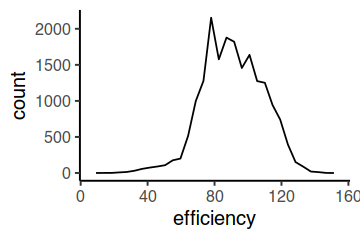

In [37]:
astart_codon_tis  %>%
  ggplot(aes(x = efficiency)) +
  geom_freqpoly(bins = 30) +

## Extract location of near cognate start codons on transcripts

In [34]:
tx_near_cognate_locations <- lapply(near_cognate_start_codons, function(x) {
    vmatchPattern(x, tx_seq) %>% 
      unlist() %>% 
      as.data.frame() 
    }) %>% 
  bind_rows(.id = "codon")  %>% 
  as_tibble() %>% 
  rename(seqnames = names) %>% 
  mutate(id = seq_along(seqnames)) %>% 
  filter(start > 6, end < width(tx_seq[seqnames]) - 2) %>% 
  left_join(tx_gene_names, by = c("seqnames" = "transcript_id")) %>%
  GRanges() %>% 
  mutate(upstream6 = as.character(tx_seq[flank_upstream(., 6)])) %>% 
  mutate(downstream2 = as.character(tx_seq[flank_downstream(., 2)])) %>% 
  print()

GRanges object with 11664232 ranges and 6 metadata columns:
                       seqnames    ranges strand |       codon        id
                          <Rle> <IRanges>  <Rle> | <character> <integer>
         [1] ENST00000000233.10     89-91      * |         ATG         1
         [2] ENST00000000233.10   140-142      * |         ATG         2
         [3] ENST00000000233.10   152-154      * |         ATG         3
         [4] ENST00000000233.10   165-167      * |         ATG         4
         [5] ENST00000000233.10   243-245      * |         ATG         5
         ...                ...       ...    ... .         ...       ...
  [11664228]  ENST00000715555.1   604-606      * |         ACG  11687635
  [11664229]  ENST00000715555.1   638-640      * |         ACG  11687636
  [11664230]  ENST00000715555.1   754-756      * |         ACG  11687637
  [11664231]  ENST00000715555.1   777-779      * |         ACG  11687638
  [11664232]  ENST00000715555.1 1206-1208      * |         ACG  

## Extract read counts at near cognate starts and join with annotated start coordinates

In [34]:
counts_near_cognate <- join_overlap_inner(tx_near_cognate_locations, aln_counts) %>%
  as_tibble() %>%
  left_join(start_codons_tx, by = c("seqnames" = "seqnames"), suffix = c("", "_start")) %>%
  print()

# A tibble: 1,681,182 × 16
   seqnames start   end width strand codon    id gene_…¹ trans…² upstr…³ downs…⁴
   <fct>    <int> <int> <int> <fct>  <chr> <int> <chr>   <chr>   <chr>   <chr>  
 1 ENST000…    89    91     3 *      ATG       1 ARF5    ARF5-2… CCCGCC  GG     
 2 ENST000…    89    91     3 *      ATG       1 ARF5    ARF5-2… CCCGCC  GG     
 3 ENST000…    89    91     3 *      ATG       1 ARF5    ARF5-2… CCCGCC  GG     
 4 ENST000…    89    91     3 *      ATG       1 ARF5    ARF5-2… CCCGCC  GG     
 5 ENST000…    89    91     3 *      ATG       1 ARF5    ARF5-2… CCCGCC  GG     
 6 ENST000…    89    91     3 *      ATG       1 ARF5    ARF5-2… CCCGCC  GG     
 7 ENST000…    89    91     3 *      ATG       1 ARF5    ARF5-2… CCCGCC  GG     
 8 ENST000…    89    91     3 *      ATG       1 ARF5    ARF5-2… CCCGCC  GG     
 9 ENST000…    89    91     3 *      ATG       1 ARF5    ARF5-2… CCCGCC  GG     
10 ENST000…   140   142     3 *      ATG       2 ARF5    ARF5-2… AAGCAG  CG     
#

## What are annotated starts with non-AUG codons?

In [80]:
start_codons_tx %>% 
  left_join(as_tibble(tx_near_cognate_locations), by = "seqnames", suffix = c("_start", "")) %>% 
  filter(start_start == start, codon != "ATG") %>% 
  left_join(tx_gene_names, by = c("seqnames" = "transcript_id")) %>% 
  write_csv("temp.csv") %>%
  print()

# A tibble: 36 × 15
   seqna…¹ start…² end_s…³ start   end width strand codon     id gene_…⁴ trans…⁵
   <chr>     <int>   <int> <int> <int> <int> <fct>  <chr>  <int> <chr>   <chr>  
 1 ENST00…     108     110   108   110     3 *      CTG   1.73e6 RNF187  RNF187…
 2 ENST00…     393     395   393   395     3 *      ACG   1.16e7 WDR26   WDR26-…
 3 ENST00…     167     169   167   169     3 *      ATA   5.98e6 FNDC5   FNDC5-…
 4 ENST00…      78      80    78    80     3 *      CTG   2.94e6 MORN2   MORN2-…
 5 ENST00…     157     159   157   159     3 *      CTG   2.43e6 PIGX    PIGX-2…
 6 ENST00…     135     137   135   137     3 *      CTG   2.74e6 TXNRD3  TXNRD3…
 7 ENST00…     223     225   223   225     3 *      CTG   2.45e6 NR1I2   NR1I2-…
 8 ENST00…     379     381   379   381     3 *      TTG   5.23e6 STIM2   STIM2-…
 9 ENST00…     108     110   108   110     3 *      CTG   1.62e6 HMHB1   HMHB1-…
10 ENST00…     232     234   232   234     3 *      ATA   5.83e6 TEAD3   TEAD3-…
# … with

## Plot relative counts for near cognate starts upstream of annotated start in each sample

### uORF alone

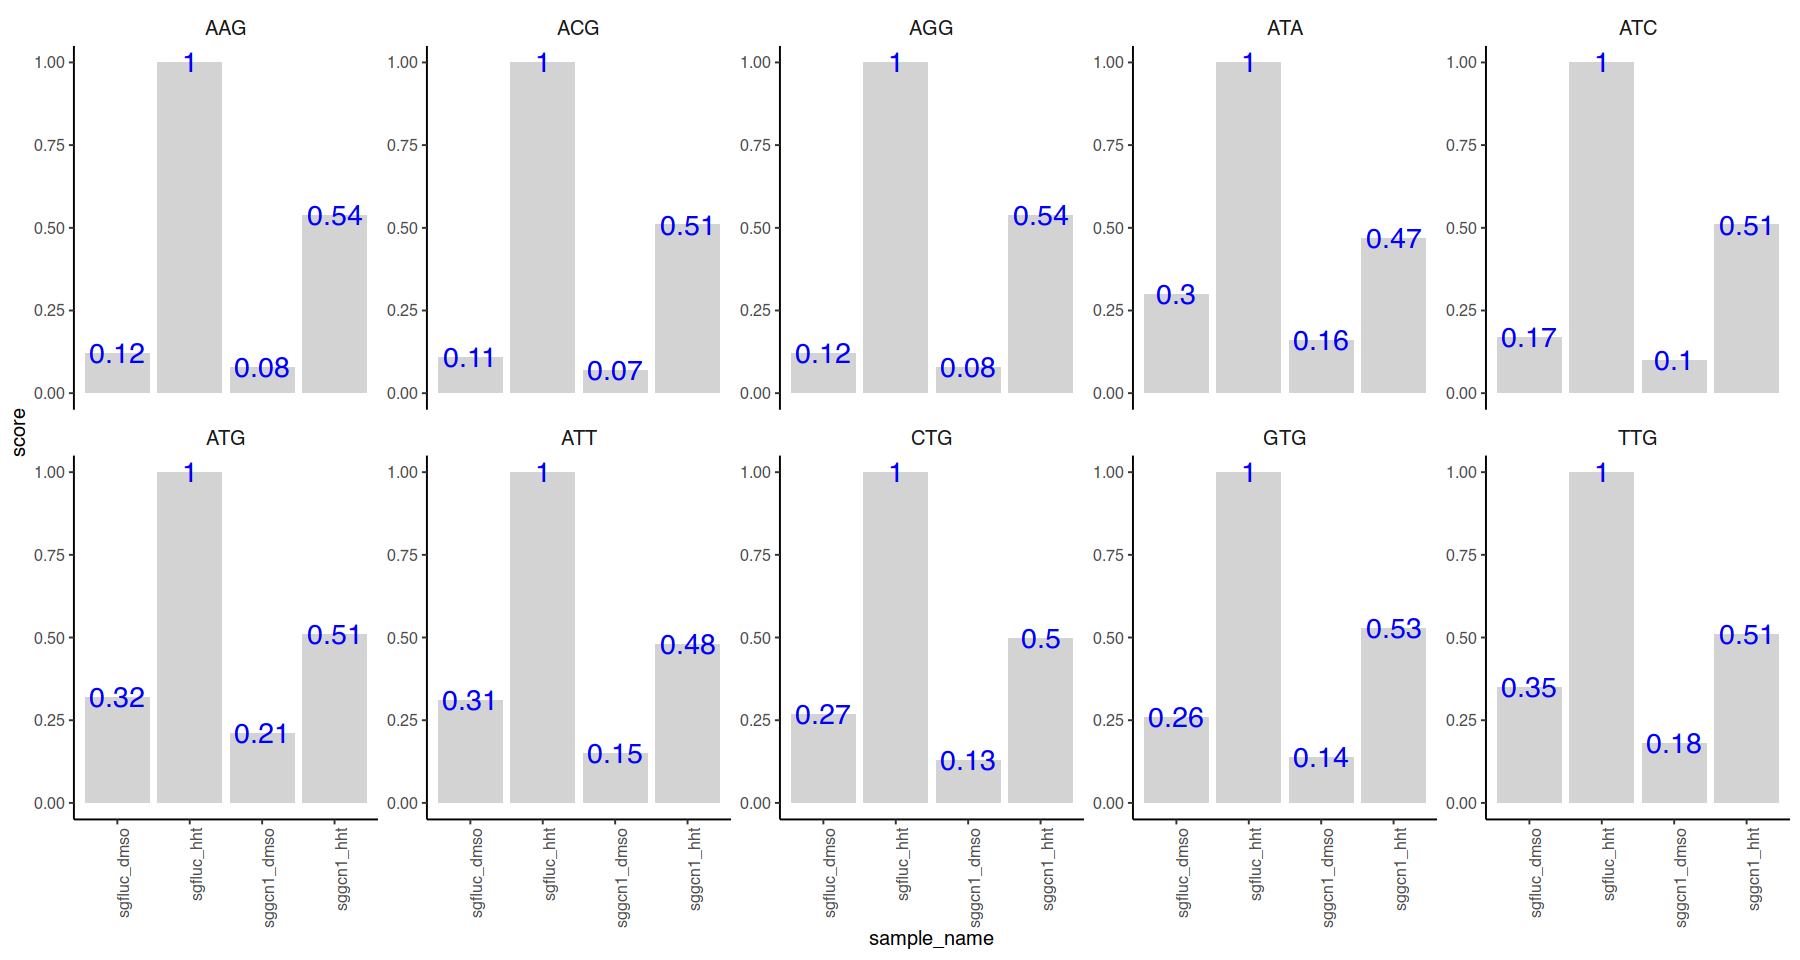

In [81]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_data <- counts_near_cognate  %>% 
  filter(start < start_start) %>% 
  group_by(sample_name, codon) %>%
  summarize(score = sum(score), .groups = "drop") %>%
  mutate(sample_name = str_replace(sample_name, "_mono", "")) %>% 
  group_by(codon) %>% 
  mutate(score = round(score / max(score), 2))

plot_data %>% 
  ggplot(aes(x = sample_name, y = score)) +
  facet_wrap(~ codon, scales = "free_y", ncol = 5) +
  geom_col(fill = "light grey", stroke = NA) +
  geom_text(aes(label = score), color = "blue", size = 6) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

## aORF

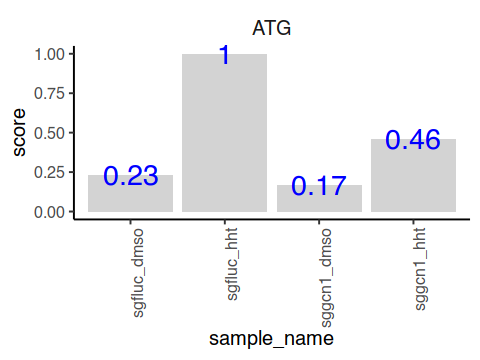

In [83]:
options(repr.plot.width = 4, repr.plot.height = 3)
plot_data <- counts_near_cognate  %>% 
  filter(start >= start_start, end <= end_start, codon == "ATG") %>% 
  group_by(sample_name, codon) %>%
  summarize(score = sum(score), .groups = "drop") %>%
  mutate(sample_name = str_replace(sample_name, "_mono", "")) %>% 
  group_by(codon) %>% 
  mutate(score = round(score / max(score), 2))

plot_data %>% 
  ggplot(aes(x = sample_name, y = score)) +
  facet_wrap(~ codon, scales = "free_y", ncol = 5) +
  geom_col(fill = "light grey", stroke = NA) +
  geom_text(aes(label = score), color = "blue", size = 6) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

### First overlapping ORF starting with ATG, stratified by annotated start efficiency

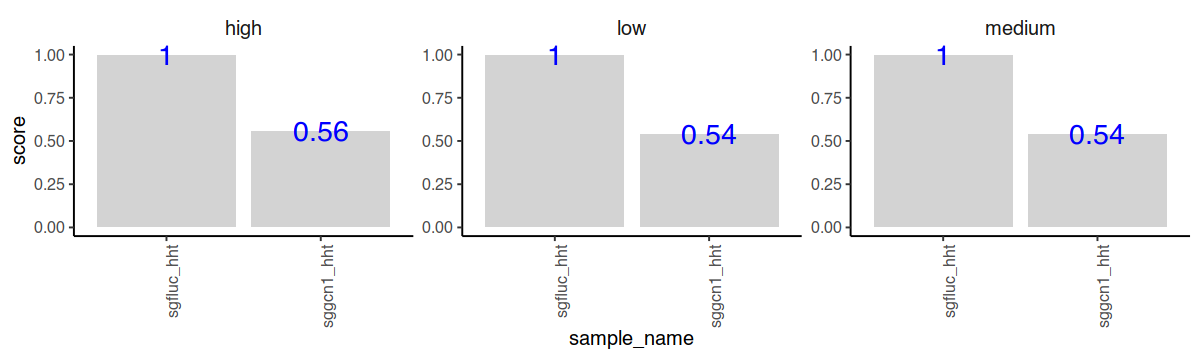

In [47]:
options(repr.plot.width = 10, repr.plot.height = 3)

plot_data <- counts_near_cognate  %>% 
  filter(start > end_start + 20, codon == "ATG") %>%
  group_by(sample_name, seqnames) %>% 
  arrange(start) %>% 
  filter(id == first(id)) %>% 
  ungroup() %>% 
  inner_join(astart_codon_tis, by = "seqnames") %>%
  filter(!is.na(efficiency)) %>%
  mutate(efficiency = case_when(
    efficiency < 78 ~ "low",
    efficiency >= 78 & efficiency < 104 ~ "medium",
    efficiency >= 104 ~ "high"
  )) %>%
  group_by(sample_name, codon, efficiency) %>%
  summarize(score = sum(score), .groups = "drop") %>%
  mutate(sample_name = str_replace(sample_name, "_mono", "")) %>% 
  filter(str_detect(sample_name, "hht")) %>% 
  group_by(codon, efficiency) %>% 
  mutate(score = round(score / max(score), 2))

plot_data %>% 
  ggplot(aes(x = sample_name, y = score)) +
  facet_wrap(~ efficiency, scales = "free_y", ncol = 5) +
  geom_col(fill = "light grey", stroke = NA) +
  geom_text(aes(label = score), color = "blue", size = 6) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Compare counts for individual near cognate starts between sgGCN1 and  sgFLUC

In [73]:
gcn1_vs_fluc_starts <- counts_near_cognate  %>%
  group_by(sample_name, id, gene_name, start, start_start, codon) %>%
  summarize(score = sum(score), .groups = "drop") %>%
  mutate(drug = str_extract(sample_name, "hht|dmso")) %>%
  mutate(sgrna = str_extract(sample_name, "fluc|gcn1")) %>%
  select(-sample_name) %>%
  pivot_wider(names_from = sgrna, values_from = score, values_fill = 1) %>%
  filter(fluc + gcn1 >= 10)

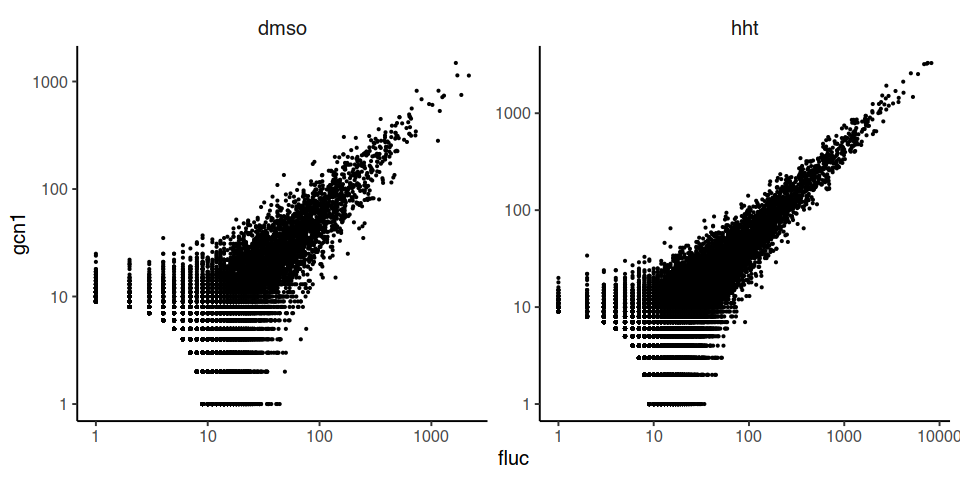

In [74]:
options(repr.plot.width = 8, repr.plot.height = 4)

gcn1_vs_fluc_starts %>%
  filter(start <= start_start + 100) %>%
  ggplot(aes(x = fluc, y = gcn1)) +
  facet_wrap(~ drug, scales = "free") +
  geom_point(size = 0.5) +
  scale_x_log10() +
  scale_y_log10()

In [75]:
lfc_starts <- gcn1_vs_fluc_starts %>%
  filter(start <= start_start + 100) %>%
  mutate(lfc = log2(gcn1 / fluc)) %>%
  group_by(drug) %>%
  mutate(lfc = lfc - median(lfc)) %>%
  ungroup()

In [80]:
lfc_starts  %>%
  arrange(desc(lfc)) %>%
  mutate(case_when(
    start < start_start ~ "upstream",
    start >= start_start & start < start_start + 15 ~ "start",
    start >= start_start + 15 ~ "downstream"
  )) %>%
  write_csv("../tables/gcn1_vs_fluc_starts_lfc.csv")

In [79]:
counts_near_cognate  %>%
  filter(gene_name == "JUN", start == start_start)

seqnames,start,end,width,strand,codon,id,gene_name,transcript_name,upstream6,downstream2,sample_name,score,psite,start_start,end_start
<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
ENST00000371222.4,978,980,3,*,ATG,674538,JUN,JUN-201,TGTTCT,AC,sggcn1_hht_mono,1,978,978,980
ENST00000371222.4,978,980,3,*,ATG,674538,JUN,JUN-201,TGTTCT,AC,sggcn1_hht_mono,1,980,978,980
